# A Machine Learning journey from customer reviews to business insights
# *Part 4: Word clouds*

*Author: Federica Lionetto*  
*Email: federica.lionetto@gmail.com*  
*Date: 17 November 2020*  
*License: Creative Commons BY-NC-SA*

*Based on the dataset available at:*
- https://www.kaggle.com/efehandanisman/skytrax-airline-reviews

### Further readings

- "Generating WordClouds in Python", https://www.datacamp.com/community/tutorials/wordcloud-python

## 0 - Configuration

In [1]:
df_types_filename = '../Results/NLPFinalDataLightTypes.csv'
df_filename = '../Results/NLPFinalDataLight.csv'
df_preds_filename = '../Results/Preds-WithText.csv'

## 1 - Import modules and helper functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

import nltk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import importlib

In [3]:
# Debugging capabilities.
import pdb

In [4]:
import sys  
sys.path.insert(0, './helper_functions')

In [5]:
# Related to recommendation.
import assign_label_recommended

# Related to word clouds.
import get_wordcloud
import get_df_word_importance

# Related to visualization.
import plot_word_cloud_diff

## 2 - Load the input data

In [6]:
# Type of each field in the input data.
df_dtype = pd.read_csv(df_types_filename)
dict_dtype = df_dtype[['index','dtypes']].set_index('index').to_dict()['dtypes']
dict_dtype['recommended'] = 'bool'

In [7]:
# Input data.
df = pd.read_csv(df_filename, dtype=dict_dtype, keep_default_na=False, na_values=['_'])
df.drop(columns=['Unnamed: 0'],inplace=True)

In [8]:
# Predictions.
df_preds = pd.read_csv(df_preds_filename)
df_preds.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
df_combined = pd.concat([df,df_preds],axis=1)

In [10]:
df_combined.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,y_pred,y_prob
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,1.0,0.945373
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.0,0.010704
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,0.0,0.024670
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,1.0,0.995231
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.0,0.002815


In [11]:
df_combined.shape

(22822, 2468)

Get the names of the colums in the dataset.

In [12]:
cols = df_combined.columns.to_list()
print('Columns in the dataset:')
print(cols)

Columns in the dataset:
['airline', 'review_score', 'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_text', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters', 'pos_neu_neg_review_score', 'has_layover', 'recommended', 'polarity', 'review_text_clean', 'count_aa', 'count_ababa', 'count_ability', 'count_able', 'count_aboard', 'count_abrupt', 'count_absolute', 'count_absolutely', 'count_abu', 'count_abysmal', 'count_ac', 'count_accept', 'count_acceptable', 'count_access', 'count_accommodate', 'count_accommodation', 'count_accompany', 'count_accord', 'count_account', 'count_acknowledge', 'count_across', 'count_act', 'count_action', 'count_active', 'count_actual', 'count_actually', 'count_ad', 'count_add', 'count_addis', 'count_addition', 'count_additional', 'count_additionally', 'cou

Get the total number of customer reviews in the dataset.

In [13]:
n_reviews = df_combined.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 22822


### 2.1 - Add the label to the dataset

In [14]:
df_combined['label'] = df_combined.apply(lambda x: assign_label_recommended.assign_label_recommended(x), axis=1)

In [15]:
df_combined.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,y_pred,y_prob,label
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,1.0,0.945373,1
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0.0,0.010704,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0.0,0.024670,0
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,1.0,0.995231,1
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0.0,0.002815,0


## 3 - Word clouds

### 3.1 - Define subset for word cloud

First scenario: all customer reviews that are predicted to be positive vs. all customer reviews that are predicted to be negative.

In [16]:
review_subscores_feats = ['seat_comfort','cabin_service','food_bev','ground_service','entertainment','value_for_money']
sel_feats = review_subscores_feats+['review_text_clean','y_pred','y_prob','label','traveller_type']

In [17]:
df_pred_rec = df_combined[sel_feats][df_combined['y_prob']>=0.9]
df_pred_not_rec = df_combined[sel_feats][df_combined['y_prob']<=0.1]

In [18]:
print('Number of predicted positive customer reviews: {:d}'.format(df_pred_rec.shape[0]))
print('Number of predicted negative customer reviews: {:d}'.format(df_pred_not_rec.shape[0]))

Number of predicted positive customer reviews: 9477
Number of predicted negative customer reviews: 10012


In [19]:
all_text_pred_rec = " ".join(review for review in df_pred_rec.review_text_clean)
all_text_pred_not_rec = " ".join(review for review in df_pred_not_rec.review_text_clean)

Second scenario: same as above, but for two different types of traveller.

In [20]:
df_combined['traveller_type'].value_counts()

Solo Leisure      8455
Couple Leisure    5796
Family Leisure    4335
Business          4236
Name: traveller_type, dtype: int64

In [21]:
group_1 = 'Business'
group_2 = 'Family Leisure'

In [22]:
df_pred_rec_group_1 = df_combined[sel_feats][(df_combined['y_prob']>=0.9) & (df_combined['traveller_type']==group_1)]
df_pred_rec_group_2 = df_combined[sel_feats][(df_combined['y_prob']>=0.9) & (df_combined['traveller_type']==group_2)]
df_pred_not_rec_group_1 = df_combined[sel_feats][(df_combined['y_prob']<=0.1) & (df_combined['traveller_type']==group_1)]
df_pred_not_rec_group_2 = df_combined[sel_feats][(df_combined['y_prob']<=0.1) & (df_combined['traveller_type']==group_2)]

In [23]:
print('Number of predicted positive customer reviews for group 1: {:d}'.format(df_pred_rec_group_1.shape[0]))
print('Number of predicted negative customer reviews for group 1: {:d}'.format(df_pred_not_rec_group_1.shape[0]))
print('Number of predicted positive customer reviews for group 2: {:d}'.format(df_pred_rec_group_2.shape[0]))
print('Number of predicted negative customer reviews for group 2: {:d}'.format(df_pred_not_rec_group_2.shape[0]))

Number of predicted positive customer reviews for group 1: 1608
Number of predicted negative customer reviews for group 1: 1963
Number of predicted positive customer reviews for group 2: 1691
Number of predicted negative customer reviews for group 2: 2096


In [24]:
all_text_pred_rec_group_1 = " ".join(review for review in df_pred_rec_group_1.review_text_clean)
all_text_pred_not_rec_group_1 = " ".join(review for review in df_pred_not_rec_group_1.review_text_clean)
all_text_pred_rec_group_2 = " ".join(review for review in df_pred_rec_group_2.review_text_clean)
all_text_pred_not_rec_group_2 = " ".join(review for review in df_pred_not_rec_group_2.review_text_clean)

### 3.2 - Visualize word cloud

In [25]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/nanakin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
top_words = 50

In [27]:
with open('../Results/NLTKStopWordsExtended.csv', 'r') as f:
    nltk_stopwords_extended = f.read()
nltk_stopwords_extended = nltk_stopwords_extended.split(', ')
# print(nltk_stopwords_extended)

In [28]:
print('Number of stopwords after extension: {:d}'.format(len(nltk_stopwords_extended)))

Number of stopwords after extension: 318


In [29]:
# These stopwords are removed from the word clouds only, in order to visualize the factors that drives a positive/negative travel experience.
additional_stopwords = ['one',
                        'get',
                        'also',
                        'however',
                        'even',
                        'make',
                        'good',
                        'great',
                        'well',
                        'bad',
                        'would',
                        'take',
                        'use',
                        'ife',
                        'really',
                        'overall',
                        'could',
                        'much',
                        'excellent',
                        'though',
                        'like',
                        'still',
                        'although',
                        'best',
                        'quite',
                        'trip',
                        'seem',
                        'two',
                        'go',
                        'ba',
                        'swiss',
                        'never',
                        'way',
                        'back',
                        'zurich',
                        'paris',
                        'hour',
                        'flight',
                        'boeing',
                        'airbus',
                        'lot',
                        'old',
                        'bit',
                        'fly',
                        'small',
                        'year'
                       ]

In [30]:
all_stopwords = nltk_stopwords_extended+additional_stopwords

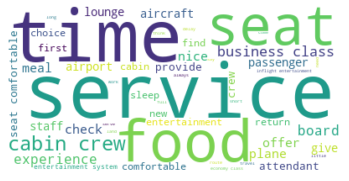

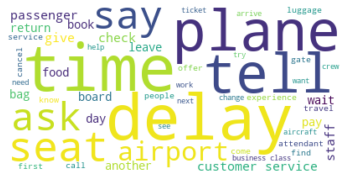

In [31]:
# First scenario.
wordcloud_pred_rec = get_wordcloud.get_wordcloud(all_text_pred_rec, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredRec.png')
wordcloud_pred_not_rec = get_wordcloud.get_wordcloud(all_text_pred_not_rec, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredNotRec.png')
dict_pred_rec = wordcloud_pred_rec.words_
dict_pred_not_rec = wordcloud_pred_not_rec.words_

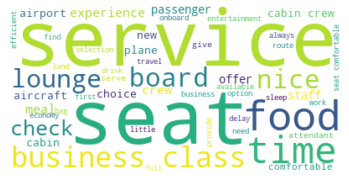

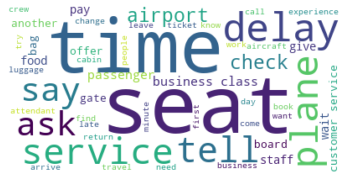

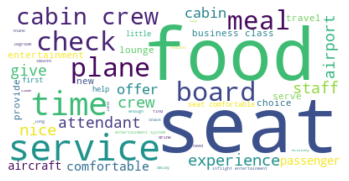

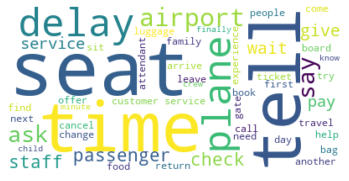

In [32]:
# Second scenario.
wordcloud_pred_rec_group_1 = get_wordcloud.get_wordcloud(all_text_pred_rec_group_1, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredRec-Group1.png')
wordcloud_pred_not_rec_group_1 = get_wordcloud.get_wordcloud(all_text_pred_not_rec_group_1, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredNotRec-Group1.png')
dict_pred_rec_group_1 = wordcloud_pred_rec_group_1.words_
dict_pred_not_rec_group_1 = wordcloud_pred_not_rec_group_1.words_

wordcloud_pred_rec_group_2 = get_wordcloud.get_wordcloud(all_text_pred_rec_group_2, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredRec-Group2.png')
wordcloud_pred_not_rec_group_2 = get_wordcloud.get_wordcloud(all_text_pred_not_rec_group_2, max_words=50, stop_words=all_stopwords, filename='../Results/04/WordCloud-PredNotRec-Group2.png')
dict_pred_rec_group_2 = wordcloud_pred_rec_group_2.words_
dict_pred_not_rec_group_2 = wordcloud_pred_not_rec_group_2.words_

In [33]:
dict_pred_rec

{'service': 1.0,
 'time': 0.9569347688410387,
 'food': 0.8299556681443951,
 'seat': 0.7713742875237493,
 'cabin crew': 0.695376820772641,
 'business class': 0.6671944268524382,
 'experience': 0.5940468651044966,
 'board': 0.5911969601013299,
 'check': 0.5497150094996833,
 'plane': 0.5487650411652945,
 'offer': 0.5345155161494617,
 'nice': 0.5313489550348321,
 'meal': 0.49841671944268523,
 'aircraft': 0.4499683343888537,
 'lounge': 0.435085497150095,
 'passenger': 0.43476884103863206,
 'staff': 0.41386953768207724,
 'give': 0.40880303989867006,
 'airport': 0.389803673210893,
 'attendant': 0.3492716909436352,
 'seat comfortable': 0.33502216592780243,
 'provide': 0.3331222292590247,
 'crew': 0.3290056998100063,
 'first': 0.29512349588347053,
 'new': 0.29512349588347053,
 'comfortable': 0.2948068397720076,
 'find': 0.2894236858771374,
 'cabin': 0.2872070930968968,
 'entertainment': 0.28372387587080433,
 'return': 0.27042431918936033,
 'choice': 0.26694110196326787,
 'sleep': 0.257124762507

In [34]:
len(list(dict_pred_rec.keys()))

50

In [35]:
# Comparison between predicted positive and predicted negative.
df_wordcloud = get_df_word_importance.get_df_word_importance(dict_1=dict_pred_rec, 
                                      dict_2=dict_pred_not_rec, 
                                      label_1='Pred Pos', 
                                      label_2='Pred Neg')

Total number of words in the two word clouds to compare: 74
             word  Pred Pos  Pred Neg      diff
0         service  1.000000  0.417197  0.582803
1            food  0.829956  0.437102  0.392854
2  business class  0.667194  0.353769  0.313426
3        aircraft  0.449968  0.278928  0.171041
4      experience  0.594047  0.433386  0.160660


In [36]:
# Comparison between predicted positive and predicted positive, for two different origin cities.
df_wordcloud_groups_comp_rec = get_df_word_importance.get_df_word_importance(dict_1=dict_pred_rec_group_1, 
                                                    dict_2=dict_pred_rec_group_2,
                                                    label_1='Pred Pos from group 1',
                                                    label_2='Pred Pos from group 2')

Total number of words in the two word clouds to compare: 62
             word  Pred Pos from group 1  Pred Pos from group 2      diff
0  business class               0.529243               0.250513  0.278729
1          lounge               0.419942               0.210472  0.209470
2         service               1.000000               0.867556  0.132444
3            nice               0.436242               0.348049  0.088192
4             new               0.297220               0.214579  0.082641


In [37]:
# Comparison between predicted negative and predicted negative, for two different origin cities.
df_wordcloud_groups_comp_not_rec = get_df_word_importance.get_df_word_importance(dict_1=dict_pred_not_rec_group_1, 
                                                            dict_2=dict_pred_not_rec_group_2,
                                                            label_1='Pred Neg from group 1',
                                                            label_2='Pred Neg from group 2')

Total number of words in the two word clouds to compare: 57
        word  Pred Neg from group 1  Pred Neg from group 2      diff
0    service               0.660797               0.482702  0.178095
1      offer               0.393883               0.308072  0.085811
2       food               0.472660               0.388797  0.083863
3       crew               0.314180               0.245470  0.068710
4  attendant               0.346617               0.310544  0.036074


In [38]:
# Comparison between predicted positive and predicted negative, for one origin city.
df_wordcloud_one_group = get_df_word_importance.get_df_word_importance(dict_1=dict_pred_rec_group_1, 
                                                  dict_2=dict_pred_not_rec_group_1,
                                                  label_1='Pred Pos from group 1',
                                                  label_2='Pred Neg from group 1')

Total number of words in the two word clouds to compare: 74
      word  Pred Pos from group 1  Pred Neg from group 1      diff
0  service               1.000000               0.660797  0.339203
1     food               0.784276               0.472660  0.311616
2    board               0.438159               0.370714  0.067446
3    cabin               0.287632               0.230769  0.056863
4     crew               0.356663               0.314180  0.042484


In [39]:
importlib.reload(plot_word_cloud_diff)

<module 'plot_word_cloud_diff' from './helper_functions/plot_word_cloud_diff.py'>

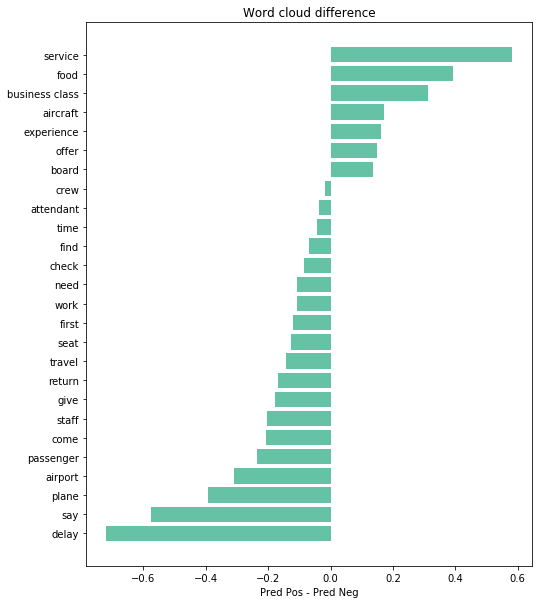

In [40]:
plot_word_cloud_diff.plot_word_cloud_diff(df_sorted=df_wordcloud,
                                          label_1='Pred Pos',
                                          label_2='Pred Neg',
                                          n_top_words=top_words,
                                          filename='../Results/04/WordCloudDiff-'+'PredPos'+'-'+'PredNeg'+'.png')

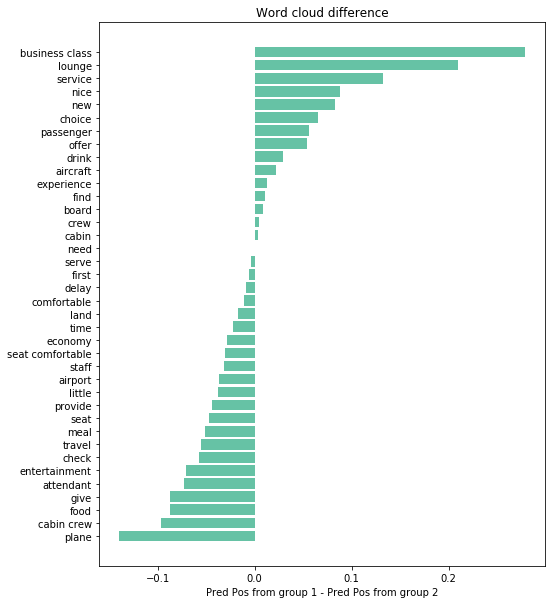

In [41]:
plot_word_cloud_diff.plot_word_cloud_diff(df_sorted=df_wordcloud_groups_comp_rec, 
                                          label_1='Pred Pos from group 1',
                                          label_2='Pred Pos from group 2',
                                          n_top_words=top_words,
                                          filename='../Results/04/WordCloudDiff-'+'PredPosGroup1'+'-'+'PredPosGroup2'+'.png')

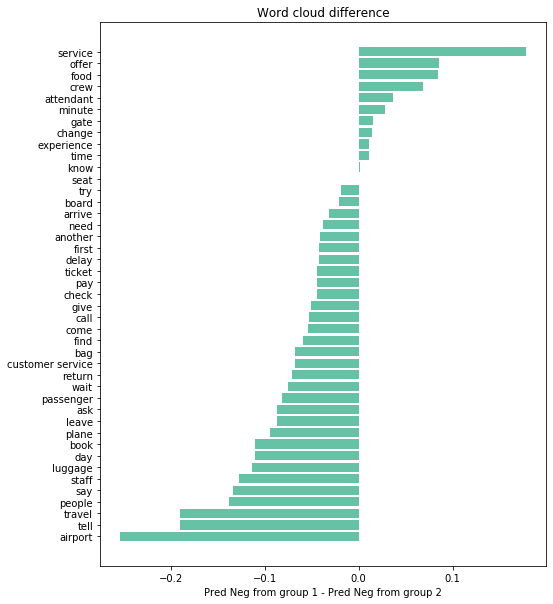

In [42]:
plot_word_cloud_diff.plot_word_cloud_diff(df_sorted=df_wordcloud_groups_comp_not_rec,
                                          label_1='Pred Neg from group 1', 
                                          label_2='Pred Neg from group 2',
                                          n_top_words=top_words,
                                          filename='../Results/04/WordCloudDiff-'+'PredNegGroup1'+'-'+'PredNegGroup2'+'.png')

We can cross-check these findings by looking at the review subscores.

In [43]:
df_pred_rec_group_1['entertainment'].describe()

count    1608.000000
mean        3.981965
std         0.991086
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: entertainment, dtype: float64

In [44]:
df_pred_rec_group_2['entertainment'].describe()

count    1691.000000
mean        4.108811
std         1.009417
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: entertainment, dtype: float64